# Comprehensive RoBERTa-based Spam Message Detection

This notebook combines all components of the spam detection project into a single file:
- Raw data preprocessing from all three sources (Enron, SMS, Telegram)
- Data merging and splitting
- Utility functions (metrics, plotting, seeding)
- Dataset handling
- SpamMessageDetector class (training, evaluation, inference)
- Visualization of dataset distributions and model performance
- Demo examples

## Table of Contents
1. [Data Preprocessing](#1-data-preprocessing)
   - 1.1 [Enron Dataset](#11-enron-dataset)
   - 1.2 [SMS Dataset](#12-sms-dataset)
   - 1.3 [Telegram Dataset](#13-telegram-dataset)
   - 1.4 [Merge Datasets](#14-merge-datasets)
   - 1.5 [Split Data](#15-split-data)
   - 1.6 [Visualize Data Distributions](#16-visualize-data-distributions)
2. [Utility Functions](#2-utility-functions)
3. [Dataset Class](#3-dataset-class)
4. [Spam Message Detector](#4-spam-message-detector)
5. [Demo and Usage Examples](#5-demo-and-usage-examples)
   - 5.1 [Training (Optional)](#51-training-optional)
   - 5.2 [Model Evaluation](#52-model-evaluation)
   - 5.3 [Testing Individual Messages](#53-testing-individual-messages)
   - 5.4 [Batch Processing](#54-batch-processing)

## 1. Data Preprocessing

First, let's install the required dependencies:

In [7]:
!pip install numpy pandas matplotlib torch transformers tqdm scikit-learn

In [8]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, get_linear_schedule_with_warmup
from tqdm import tqdm
from sklearn.model_selection import train_test_split

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

os.makedirs('data', exist_ok=True)
os.makedirs('plots', exist_ok=True)

### 1.1 Enron Dataset

Process the Enron email dataset:

In [9]:
def preprocess_enron():
    print("Processing Enron dataset...")
    df = pd.read_csv('/content/enron_spam_data.csv')
    df_filtered = df[['Spam/Ham', 'Message']]
    df_filtered.rename(columns={'Spam/Ham': 'label', 'Message': 'text'}, inplace=True)
    df_filtered.dropna(subset=['text'], inplace=True)
    df_filtered['text'] = df_filtered['text'].apply(lambda x: x.replace('\n', ' ').strip() if isinstance(x, str) else x)
    print(f"Enron dataset processed: {len(df_filtered)} samples")
    return df_filtered

enron_df = preprocess_enron()
enron_df.head()

Processing Enron dataset...


<ipython-input-9-4e1c5452e10c>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered.rename(columns={'Spam/Ham': 'label', 'Message': 'text'}, inplace=True)
<ipython-input-9-4e1c5452e10c>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered.dropna(subset=['text'], inplace=True)
<ipython-input-9-4e1c5452e10c>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filter

Enron dataset processed: 33345 samples


,label,text
1,ham,"gary , production from the high island larger ..."
2,ham,- calpine daily gas nomination 1 . doc
3,ham,fyi - see note below - already done . stella -...
4,ham,fyi . - - - - - - - - - - - - - - - - - - - - ...
5,ham,"jackie , since the inlet to 3 river plant is s..."


### 1.2 SMS Dataset

Process the SMS spam dataset:

In [10]:
def preprocess_sms():
    print("Processing SMS dataset...")
    df = pd.read_csv('/content/sms_spam.csv')
    if 'v1' in df.columns and 'v2' in df.columns:
        df_filtered = df[['v1', 'v2']]
        df_filtered.rename(columns={'v1': 'label', 'v2': 'text'}, inplace=True)
    elif 'type' in df.columns and 'text' in df.columns:
        df_filtered = df[['type', 'text']]
        df_filtered.rename(columns={'type': 'label'}, inplace=True)
    else:
        df_filtered = df.iloc[:, 0:2]
        df_filtered.columns = ['label', 'text']
    df_filtered['label'] = df_filtered['label'].apply(lambda x: 'spam' if x.lower() in ['spam', '1'] else 'ham')
    df_filtered.dropna(subset=['text'], inplace=True)
    df_filtered['text'] = df_filtered['text'].apply(lambda x: x.replace('\n', ' ').strip() if isinstance(x, str) else x)
    print(f"SMS dataset processed: {len(df_filtered)} samples")
    return df_filtered

try:
    sms_df = preprocess_sms()
    sms_df.head()
except Exception as e:
    print(f"Error processing SMS dataset: {e}")
    sms_df = pd.DataFrame(columns=['label', 'text'])

Processing SMS dataset...
SMS dataset processed: 5572 samples


### 1.3 Telegram Dataset

Process the Telegram spam dataset:

In [11]:
def preprocess_telegram():
    print("Processing Telegram dataset...")
    df = pd.read_csv('/content/telegram_spam_dataset.csv')
    if 'label' in df.columns and 'text' in df.columns:
        df_filtered = df[['label', 'text']]
    else:
        df_filtered = df.iloc[:, 0:2]
        df_filtered.columns = ['label', 'text']
    df_filtered.dropna(subset=['text'], inplace=True)
    df_filtered['text'] = df_filtered['text'].apply(lambda x: x.replace('\n', ' ').strip() if isinstance(x, str) else x)
    print(f"Telegram dataset processed: {len(df_filtered)} samples")
    return df_filtered

try:
    telegram_df = preprocess_telegram()
    telegram_df.head()
except Exception as e:
    print(f"Error processing Telegram dataset: {e}")
    telegram_df = pd.DataFrame(columns=['label', 'text'])

Processing Telegram dataset...
Telegram dataset processed: 20324 samples


### 1.4 Merge Datasets

Combine all three datasets into one:

In [12]:
def merge_datasets(dfs):
    print("Merging datasets...")
    merged_df = pd.concat(dfs, ignore_index=True)
    merged_df.drop_duplicates(subset=['text'], inplace=True)
    print(f"Total merged dataset size: {len(merged_df)} samples")
    print(f"Spam samples: {len(merged_df[merged_df['label'] == 'spam'])}")
    print(f"Ham samples: {len(merged_df[merged_df['label'] == 'ham'])}")
    return merged_df

merged_df = merge_datasets([enron_df, sms_df, telegram_df])
merged_df.head()

Merging datasets...
Total merged dataset size: 54839 samples
Spam samples: 20548
Ham samples: 34291


,label,text
0,ham,"gary , production from the high island larger ..."
1,ham,- calpine daily gas nomination 1 . doc
2,ham,fyi - see note below - already done . stella -...
3,ham,fyi . - - - - - - - - - - - - - - - - - - - - ...
4,ham,"jackie , since the inlet to 3 river plant is s..."


### 1.5 Split Data

Split the merged dataset into training, validation, and test sets:

In [13]:
def split_data(df, train_size=0.8, val_size=0.1, test_size=0.1):
    print("Splitting data into train, validation, and test sets...")
    train_val_df, test_df = train_test_split(
        df,
        test_size=test_size,
        random_state=SEED,
        stratify=df['label']
    )
    train_df, val_df = train_test_split(
        train_val_df,
        test_size=val_size / (train_size + val_size),
        random_state=SEED,
        stratify=train_val_df['label']
    )
    print(f"Train set size: {len(train_df)}")
    print(f"Validation set size: {len(val_df)}")
    print(f"Test set size: {len(test_df)}")
    train_df.to_csv('data/spam_message_train.csv', index=False)
    val_df.to_csv('data/spam_message_val.csv', index=False)
    test_df.to_csv('data/spam_message_test.csv', index=False)
    return train_df, val_df, test_df

train_df, val_df, test_df = split_data(merged_df)

Splitting data into train, validation, and test sets...
Train set size: 43871
Validation set size: 5484
Test set size: 5484


### 1.6 Visualize Data Distributions

Create visualizations for the data distributions:

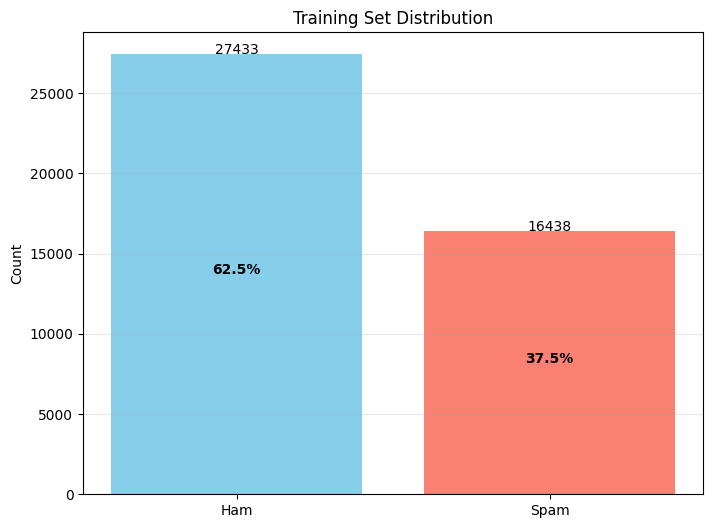

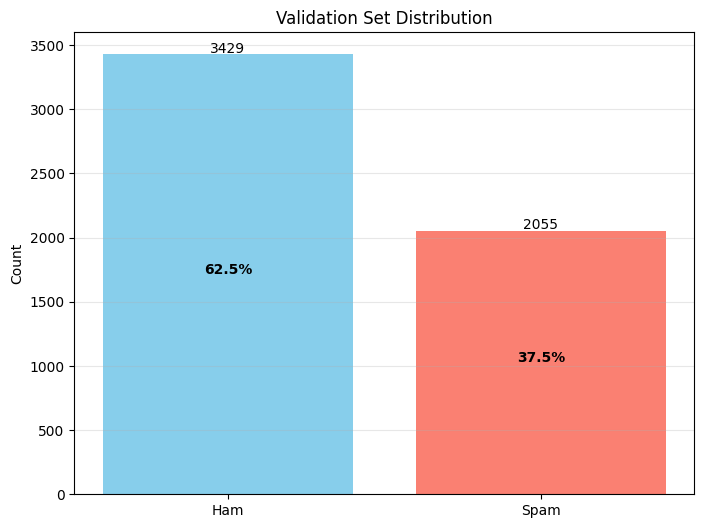

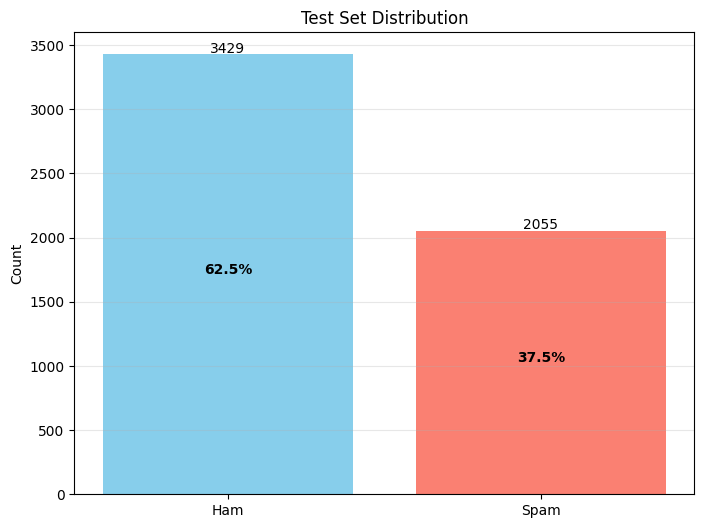

In [14]:
def visualize_distribution(df, title, save_path=None):
    count_spam = len(df[df['label'] == 'spam'])
    count_ham = len(df[df['label'] == 'ham'])
    plt.figure(figsize=(8, 6))
    plt.bar(['Ham', 'Spam'], [count_ham, count_spam], color=['skyblue', 'salmon'])
    plt.title(title)
    plt.ylabel('Count')
    plt.grid(axis='y', alpha=0.3)
    for i, count in enumerate([count_ham, count_spam]):
        plt.text(i, count + 10, str(count), ha='center')
    total = count_ham + count_spam
    plt.text(0, count_ham/2, f'{count_ham/total:.1%}', ha='center', color='black', fontweight='bold')
    plt.text(1, count_spam/2, f'{count_spam/total:.1%}', ha='center', color='black', fontweight='bold')
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

visualize_distribution(train_df, 'Training Set Distribution', 'plots/train_set_distribution.jpg')
visualize_distribution(val_df, 'Validation Set Distribution', 'plots/val_set_distribution.jpg')
visualize_distribution(test_df, 'Test Set Distribution', 'plots/test_set_distribution.jpg')

## 2. Utility Functions

Now, let's implement the utility functions for metrics calculation, plotting, and random seed setting.

In [15]:
def random_seed(seed: int) -> None:
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [16]:
def compute_metrics(y_true, y_pred, positive_label="spam", negative_label="ham"):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    accuracy = np.mean(y_true == y_pred)
    tp = np.sum((y_true == positive_label) & (y_pred == positive_label))
    fp = np.sum((y_true == negative_label) & (y_pred == positive_label))
    fn = np.sum((y_true == positive_label) & (y_pred == negative_label))
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    return accuracy, precision, recall, f1

def confusion_matrix(y_true, y_pred):
    classes = list(set(y_true) | set(y_pred))
    classes.sort()
    num_classes = len(classes)
    cm = [[0] * num_classes for _ in range(num_classes)]
    for true, pred in zip(y_true, y_pred):
        true_idx = classes.index(true)
        pred_idx = classes.index(pred)
        cm[true_idx][pred_idx] += 1
    return cm

In [17]:
def plot_heatmap(cm, saveToFile=None, annot=True, fmt="d", cmap="Blues", xticklabels=None, yticklabels=None):
    cm = np.array(cm)
    fig, ax = plt.subplots(figsize=(8, 6))
    im = ax.imshow(cm, cmap=cmap)
    if annot:
        norm = Normalize(vmin=cm.min(), vmax=cm.max())
        for i in range(len(cm)):
            for j in range(len(cm[i])):
                value = cm[i, j]
                text_color = 'white' if norm(value) > 0.5 else 'black'
                ax.text(j, i, format(value, fmt), ha="center", va="center", color=text_color)
    if xticklabels:
        ax.set_xticks(np.arange(len(xticklabels)))
        ax.set_xticklabels(xticklabels)
    if yticklabels:
        ax.set_yticks(np.arange(len(yticklabels)))
        ax.set_yticklabels(yticklabels)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")
    ax.set_title("Confusion Matrix Heatmap")
    cbar = ax.figure.colorbar(im, ax=ax)
    if saveToFile is not None:
        plt.savefig(saveToFile, dpi=300, bbox_inches='tight')
    plt.show()

def save_list_to_file(lst, filename):
    os.makedirs(os.path.dirname(filename), exist_ok=True)
    with open(filename, 'w') as file:
        for item in lst:
            file.write(str(item) + '\n')

## 3. Dataset Class

Now, we'll implement the custom dataset class for handling spam message data.

In [18]:
class SpamMessageDataset(Dataset):
    def __init__(self, text, labels, tokenizer, max_length):
        self.text = text
        labels = [1 if label == 'spam' else 0 for label in labels]
        self.labels = torch.tensor(labels, dtype=torch.long)
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.text)

    def __getitem__(self, idx):
        text = str(self.text[idx])
        label = self.labels[idx].clone().detach()
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        input_ids = encoding['input_ids'].squeeze()
        attention_mask = encoding['attention_mask'].squeeze()
        return {
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'label': label
        }

## 4. Spam Message Detector

Next, we'll implement the main SpamMessageDetector class that handles model training, evaluation, and inference.

In [19]:
class SpamMessageDetector:
    def __init__(self, model_path, max_length=512, seed=0):
        random_seed(seed)
        self.seed = seed
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        print(f"Using device: {self.device}")
        self.tokenizer = DistilBertTokenizer.from_pretrained(model_path)
        self.model = DistilBertForSequenceClassification.from_pretrained(model_path, num_labels=2)
        self.model = self.model.to(self.device)
        self.max_length = max_length

    def train(self, train_data_path, val_data_path=None, num_epochs=5, batch_size=32, learning_rate=2e-5):
        random_seed(self.seed)
        if(val_data_path is None):
            data = pd.read_csv(train_data_path)
            text = data['text'].values
            labels = data['label'].values
            dataset = SpamMessageDataset(text, labels, self.tokenizer, max_length=self.max_length)
            train_size = int(0.8 * len(dataset))
            val_size = len(dataset) - train_size
            train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
        else:
            train_data = pd.read_csv(train_data_path)
            train_text = train_data['text'].values
            train_labels = train_data['label'].values
            train_dataset = SpamMessageDataset(train_text, train_labels, self.tokenizer, max_length=self.max_length)
            val_data = pd.read_csv(val_data_path)
            val_text = val_data['text'].values
            val_labels = val_data['label'].values
            val_dataset = SpamMessageDataset(val_text, val_labels, self.tokenizer, max_length=self.max_length)
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size)
        optimizer = torch.optim.AdamW(self.model.parameters(), lr=learning_rate)
        total_steps = len(train_loader) * num_epochs
        scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=100, num_training_steps=total_steps)
        train_losses = []
        val_losses = []
        val_accuracies = []
        val_precisions = []
        val_recalls = []
        val_f1_scores = []
        for epoch in range(num_epochs):
            self.model.train()
            train_loss = 0.0
            progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}', leave=True)
            for batch in progress_bar:
                input_ids = batch['input_ids'].to(self.device)
                attention_mask = batch['attention_mask'].to(self.device)
                labels = batch['label'].to(self.device)
                optimizer.zero_grad()
                outputs = self.model(input_ids, attention_mask=attention_mask, labels=labels)
                loss = outputs.loss
                train_loss += loss.item()
                loss.backward()
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)
                optimizer.step()
                scheduler.step()
                progress_bar.set_postfix({'Training Loss': train_loss / (progress_bar.n + 1)})
            train_loss /= len(train_loader)
            train_losses.append(train_loss)
            self.model.eval()
            val_loss = 0.0
            y_true = []
            y_pred = []
            with torch.no_grad():
                for batch in val_loader:
                    input_ids = batch['input_ids'].to(self.device)
                    attention_mask = batch['attention_mask'].to(self.device)
                    labels = batch['label'].to(self.device)
                    outputs = self.model(input_ids, attention_mask=attention_mask, labels=labels)
                    loss = outputs.loss
                    logits = outputs.logits
                    val_loss += loss.item()
                    predictions = torch.argmax(logits, dim=1)
                    y_true.extend(labels.cpu().numpy())
                    y_pred.extend(predictions.cpu().numpy())
            val_loss /= len(val_loader)
            val_losses.append(val_loss)
            y_true_labels = ['spam' if y == 1 else 'ham' for y in y_true]
            y_pred_labels = ['spam' if y == 1 else 'ham' for y in y_pred]
            accuracy, precision, recall, f1 = compute_metrics(y_true_labels, y_pred_labels)
            val_accuracies.append(accuracy)
            val_precisions.append(precision)
            val_recalls.append(recall)
            val_f1_scores.append(f1)
            print(f'Epoch {epoch + 1}/{num_epochs} - '
                  f'Train Loss: {train_loss:.4f} - Val Loss: {val_loss:.4f} - '
                  f'Val Accuracy: {accuracy:.4f} - Val Precision: {precision:.4f} - '
                  f'Val Recall: {recall:.4f} - Val F1: {f1:.4f}')
        os.makedirs('plots', exist_ok=True)
        save_list_to_file(train_losses, "plots/train_losses.txt")
        save_list_to_file(val_losses, "plots/val_losses.txt")
        save_list_to_file(val_accuracies, "plots/val_accuracies.txt")
        save_list_to_file(val_precisions, "plots/val_precisions.txt")
        save_list_to_file(val_recalls, "plots/val_recalls.txt")
        save_list_to_file(val_f1_scores, "plots/val_f1_scores.txt")
        plt.figure(figsize=(10, 6))
        plt.plot(train_losses, label='Training Loss')
        plt.plot(val_losses, label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Training and Validation Loss')
        plt.legend()
        plt.savefig('plots/train_validation_loss.jpg', dpi=300, bbox_inches='tight')
        plt.show()
        plt.figure(figsize=(10, 6))
        plt.plot(val_accuracies, label='Validation Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.title('Validation Accuracy')
        plt.legend()
        plt.savefig('plots/validation_accuracy.jpg', dpi=300, bbox_inches='tight')
        plt.show()
        plt.figure(figsize=(10, 6))
        plt.plot(val_precisions, label='Validation Precision')
        plt.plot(val_recalls, label='Validation Recall')
        plt.xlabel('Epoch')
        plt.ylabel('Score')
        plt.title('Validation Precision and Recall')
        plt.legend()
        plt.savefig('plots/validation_precision_recall.jpg', dpi=300, bbox_inches='tight')
        plt.show()

    def evaluate(self, dataset_path):
        random_seed(self.seed)
        dataset = pd.read_csv(dataset_path)
        texts = dataset["text"].tolist()
        labels = dataset["label"].tolist()
        def preprocess(text):
            inputs = self.tokenizer.encode_plus(
                text,
                add_special_tokens=True,
                max_length=self.max_length,
                padding="max_length",
                truncation=True,
                return_tensors="pt"
            )
            return inputs["input_ids"].to(self.device), inputs["attention_mask"].to(self.device)
        predictions = []
        with torch.no_grad():
            for text in tqdm(texts, desc="Evaluating"):
                input_ids, attention_mask = preprocess(text)
                outputs = self.model(input_ids=input_ids, attention_mask=attention_mask)
                logits = outputs.logits
                predicted_label = torch.argmax(logits, dim=1).item()
                if predicted_label == 0:
                    predictions.append("ham")
                else:
                    predictions.append("spam")
        accuracy, precision, recall, f1 = compute_metrics(labels, predictions)
        cm = confusion_matrix(labels, predictions)
        labels_sorted = sorted(set(labels))
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1 Score: {f1:.4f}")
        with open('plots/evaluate_metrics.txt', 'w') as f:
            f.write(f"Accuracy: {accuracy:.4f}\n")
            f.write(f"Precision: {precision:.4f}\n")
            f.write(f"Recall: {recall:.4f}\n")
            f.write(f"F1 Score: {f1:.4f}\n")
        plot_heatmap(cm, saveToFile="plots/confusion_matrix.png", annot=True, fmt="d", cmap="Blues", xticklabels=labels_sorted, yticklabels=labels_sorted)
        return accuracy, precision, recall, f1

    def detect(self, text):
        random_seed(self.seed)
        is_str = True
        if isinstance(text, str):
            encoded_input = self.tokenizer.encode_plus(
                text,
                add_special_tokens=True,
                max_length=self.max_length,
                padding='max_length',
                truncation=True,
                return_tensors='pt'
            )
        elif isinstance(text, list):
            is_str = False
            encoded_input = self.tokenizer.batch_encode_plus(
                text,
                add_special_tokens=True,
                max_length=self.max_length,
                padding='max_length',
                truncation=True,
                return_tensors='pt'
            )
        else:
            raise Exception("text type is unsupported, needs to be str or list(str)")
        input_ids = encoded_input['input_ids'].to(self.device)
        attention_mask = encoded_input['attention_mask'].to(self.device)
        with torch.no_grad():
            outputs = self.model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        predicted_labels = torch.argmax(logits, dim=1).tolist()
        if is_str:
            return predicted_labels[0]
        else:
            return predicted_labels

    def save_model(self, model_path):
        os.makedirs(model_path, exist_ok=True)
        self.model.save_pretrained(model_path)
        self.tokenizer.save_pretrained(model_path)
        print(f"Model saved to {model_path}")

    def load_model(self, model_path):
        self.model = DistilBertForSequenceClassification.from_pretrained(model_path)
        self.tokenizer = DistilBertTokenizer.from_pretrained(model_path)
        self.model = self.model.to(self.device)
        print(f"Model loaded from {model_path}")

## 5. Demo and Usage Examples

Now let's demonstrate how to use the SpamMessageDetector for training, evaluation, and inference.

### 5.1 Training (Optional)

To train the model, set `TRAIN=True`. This step is optional as we can use the pre-trained model for evaluation and inference.

Using device: cuda


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1/5: 100%|██████████| 1371/1371 [06:42<00:00,  3.41it/s, Training Loss=0.119]


Epoch 1/5 - Train Loss: 0.1194 - Val Loss: 0.0674 - Val Accuracy: 0.9792 - Val Precision: 0.9874 - Val Recall: 0.9567 - Val F1: 0.9718


Epoch 2/5: 100%|██████████| 1371/1371 [06:40<00:00,  3.42it/s, Training Loss=0.0332]


Epoch 2/5 - Train Loss: 0.0332 - Val Loss: 0.0492 - Val Accuracy: 0.9885 - Val Precision: 0.9902 - Val Recall: 0.9791 - Val F1: 0.9846


Epoch 3/5: 100%|██████████| 1371/1371 [06:40<00:00,  3.42it/s, Training Loss=0.0125]


Epoch 3/5 - Train Loss: 0.0125 - Val Loss: 0.0639 - Val Accuracy: 0.9889 - Val Precision: 0.9892 - Val Recall: 0.9810 - Val F1: 0.9851


Epoch 4/5: 100%|██████████| 1371/1371 [06:40<00:00,  3.42it/s, Training Loss=0.00419]


Epoch 4/5 - Train Loss: 0.0042 - Val Loss: 0.0785 - Val Accuracy: 0.9876 - Val Precision: 0.9906 - Val Recall: 0.9762 - Val F1: 0.9833


Epoch 5/5: 100%|██████████| 1371/1371 [06:40<00:00,  3.42it/s, Training Loss=0.00189]


Epoch 5/5 - Train Loss: 0.0019 - Val Loss: 0.0769 - Val Accuracy: 0.9881 - Val Precision: 0.9877 - Val Recall: 0.9805 - Val F1: 0.9841


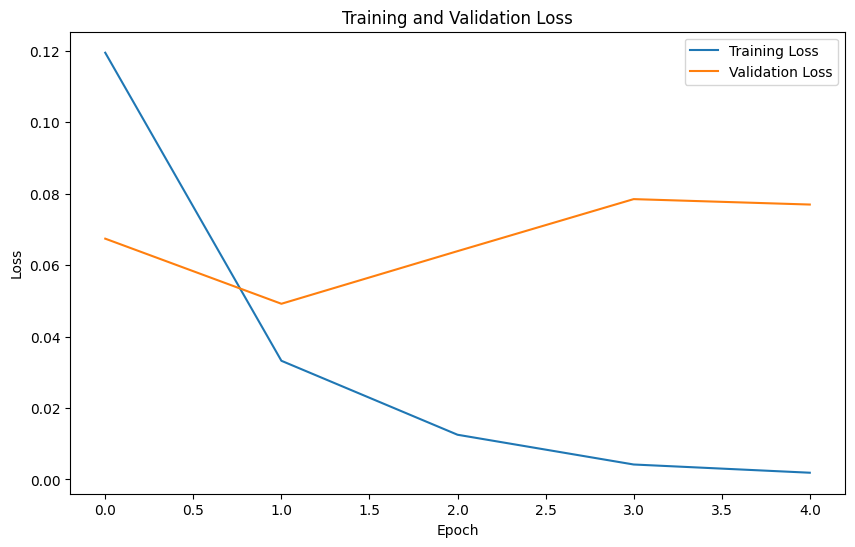

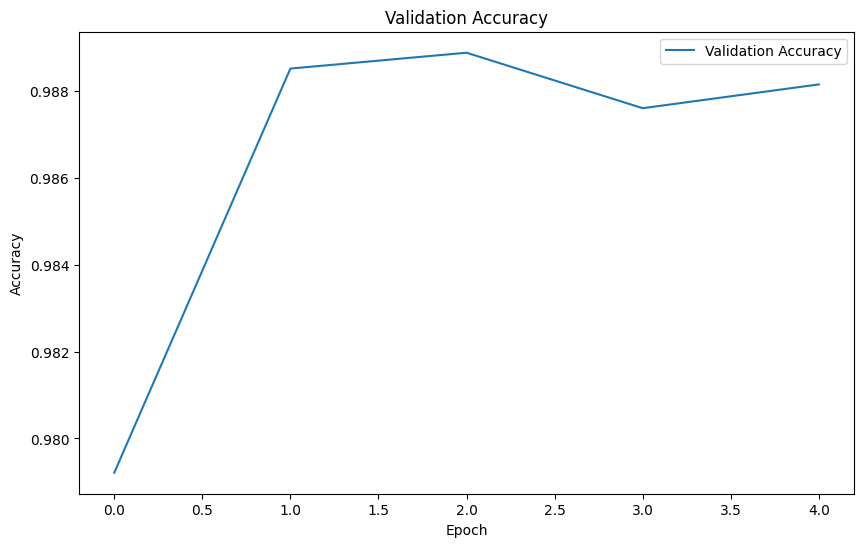

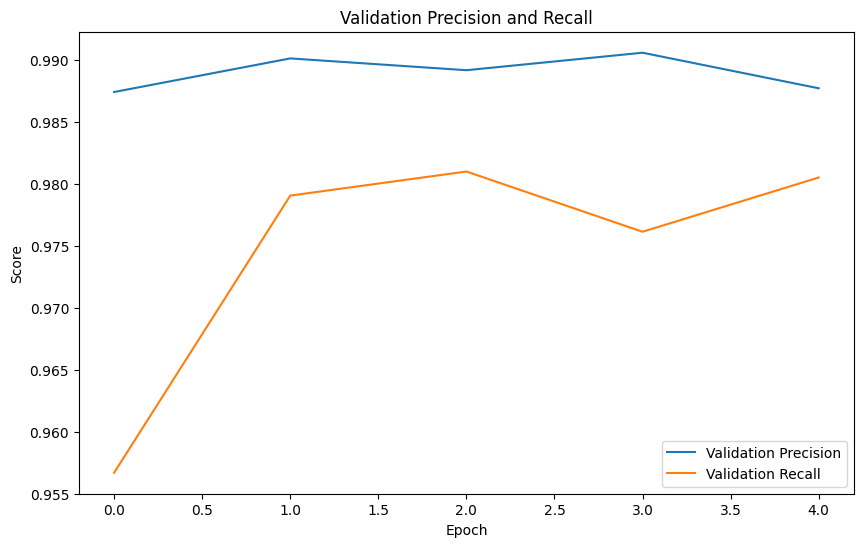

Model saved to distilbert-spam


In [20]:
TRAIN = True
if TRAIN:
    spam_detector = SpamMessageDetector("distilbert-base-uncased", max_length=512, seed=SEED)
    train_data_path = 'data/spam_message_train.csv'
    val_data_path = 'data/spam_message_val.csv'
    spam_detector.train(train_data_path, val_data_path, num_epochs=5, batch_size=32, learning_rate=2e-5)
    model_path = 'distilbert-spam'
    spam_detector.save_model(model_path)

#### Training Results Visualization

Loss    |  Accuracy      |  Precision / Recall            
:-------------------------:|:-------------------------:|:-------------------------:
![](plots/train_validation_loss.jpg "Train / Validation Loss") Train / Validation | ![](plots/validation_accuracy.jpg "Validation Accuracy") Validation | ![](plots/validation_precision_recall.jpg "Validation Precision / Recall")  Validation

### 5.2 Model Evaluation

Let's evaluate the pre-trained model on the test dataset.

Using device: cuda


Evaluating: 100%|██████████| 5484/5484 [00:44<00:00, 122.80it/s]


Accuracy: 0.9845
Precision: 0.9828
Recall: 0.9757
F1 Score: 0.9792


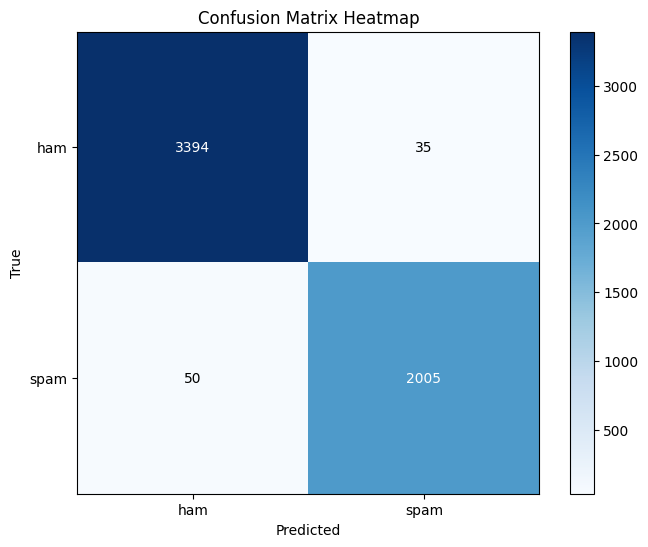

(np.float64(0.9845003646973013),
 np.float64(0.9828431372549019),
 np.float64(0.975669099756691),
 np.float64(0.9792429792429793))

In [21]:
try:
    if os.path.exists('distilbert-spam'):
        spam_detector = SpamMessageDetector("distilbert-spam", max_length=512, seed=SEED)
    else:
        spam_detector = SpamMessageDetector("distilbert-base-uncased", max_length=512, seed=SEED)
except Exception as e:
    print(f"Error loading model: {e}")
    spam_detector = SpamMessageDetector("distilbert-base-uncased", max_length=512, seed=SEED)
spam_detector.evaluate("data/spam_message_test.csv")

### 5.3 Testing Individual Messages

Let's test the model on individual messages to see how it classifies them.

In [22]:
message1 = "Hey so this sat are we going for the intro pilates only? Or the kickboxing too?"
detection = spam_detector.detect(message1)
print("\nExample 1")
print("Input Message: ", message1)
print("Detected Spam?: ", bool(detection))
message2 = "U have a secret admirer. REVEAL who thinks U R So special. Call 09065174042. To opt out Reply REVEAL STOP. 1.50 per msg recd."
detection = spam_detector.detect(message2)
print("\nExample 2")
print("Input Message: ", message2)
print("Detected Spam?: ", bool(detection))
message3 = "Dude im no longer a pisces. Im an aquarius now."
detection = spam_detector.detect(message3)
print("\nExample 3")
print("Input Message: ", message3)
print("Detected Spam?: ", bool(detection))
message4 = "Great News! Call FREEFONE 08006344447 to claim your guaranteed $1000 CASH or $2000 gift. Speak to a live operator NOW!"
detection = spam_detector.detect(message4)
print("\nExample 4")
print("Input Message: ", message4)
print("Detected Spam?: ", bool(detection))


Example 1
Input Message:  Hey so this sat are we going for the intro pilates only? Or the kickboxing too?
Detected Spam?:  False

Example 2
Input Message:  U have a secret admirer. REVEAL who thinks U R So special. Call 09065174042. To opt out Reply REVEAL STOP. 1.50 per msg recd.
Detected Spam?:  True

Example 3
Input Message:  Dude im no longer a pisces. Im an aquarius now.
Detected Spam?:  False

Example 4
Input Message:  Great News! Call FREEFONE 08006344447 to claim your guaranteed $1000 CASH or $2000 gift. Speak to a live operator NOW!
Detected Spam?:  True


### 5.4 Batch Processing

The model also supports batch processing for detecting spam in multiple messages at once.

In [23]:
messages = [message1, message2, message3, message4]

In [24]:
detections = spam_detector.detect(messages)
for i, message in enumerate(messages):
    print("\nExample ", f"{i+1}")
    print("Input Message: ", message)
    print("Detected Spam?: ", bool(detections[i]))


Example  1
Input Message:  Hey so this sat are we going for the intro pilates only? Or the kickboxing too?
Detected Spam?:  False

Example  2
Input Message:  U have a secret admirer. REVEAL who thinks U R So special. Call 09065174042. To opt out Reply REVEAL STOP. 1.50 per msg recd.
Detected Spam?:  True

Example  3
Input Message:  Dude im no longer a pisces. Im an aquarius now.
Detected Spam?:  False

Example  4
Input Message:  Great News! Call FREEFONE 08006344447 to claim your guaranteed $1000 CASH or $2000 gift. Speak to a live operator NOW!
Detected Spam?:  True
